In [1]:
import numpy as np
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy
import matplotlib.colors as pltcolors
import random

In [2]:
#Function to extract data
def getData(file_name):
    file_handle = open(file_name + ".txt", "r")
    lines = file_handle.readlines()
    gene_ids = []
    ground_truth_clusters = []
    input_matrix = []
    for line in lines:
        row = line.strip().split("\t")
        gene_ids.append(int(row.pop(0)))
        ground_truth_clusters.append(int(row.pop(0)))
        att_list=[float(i) for i in row]
        input_matrix.append(att_list)
    return np.array(gene_ids), np.array(ground_truth_clusters), np.array(input_matrix)

In [3]:
file_name = "dbscan_tab_seperated"
gene_ids, ground_truth_clusters, input_matrix = getData(file_name)

#Function to calculate the distance matrix of the data points
DistanceMatrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(input_matrix, 'euclidean'))

In [4]:
def DBScanClustering(Epsilon, minPts, DistMat):
    
    VisitedPoints = np.zeros(len(DistMat))

    finalClusterNumber = np.zeros(len(DistMat))
    
    C=0
    
    for i in range(len(DistMat)):

        if VisitedPoints[i] == 0:
            
            NeighborPoints=rangeQuery(i, DistMat, Epsilon)

            if len(NeighborPoints)<minPts:
                VisitedPoints[i] = -1
                finalClusterNumber[i] = int(-1)
                
            else:
                C = C+1

                finalClusterNumber = expandCluster(i, list(NeighborPoints),minPts,Epsilon,VisitedPoints,DistanceMatrix,finalClusterNumber,C)

    return finalClusterNumber.astype(int)


def expandCluster(j, N_Points,minPts,Epsilon,Visited,DistMat,clusterNumber,C):
    Neighbors=[] 
    
    clusterNumber[j]=int(C)
    for i in N_Points:
        if(Visited[i] == -1):
            Visited[i] = 1
            clusterNumber[i] = int(C)
        elif Visited[i]==0:
            Visited[i]=1
            Neighbors=rangeQuery(i, DistMat, Epsilon)
            if len(Neighbors)>=minPts:
                for j in Neighbors:
                    if j not in N_Points:
                        N_Points.append(j)                 
            if clusterNumber[i]==0:
                clusterNumber[i]=int(C)
    return clusterNumber

def rangeQuery(i, DistanceMatrix, Eps):
    #NeighborList = np.where(DistanceMatrix[i]<Eps)[0]
    #print(i)
    #print(np.where(DistanceMatrix[i]<Eps)[0])
    return np.where(DistanceMatrix[i]<Eps)[0]
    

In [5]:
Epsilon = 0.15
minPoints = 5
cluster_list = DBScanClustering(Epsilon, minPoints, DistanceMatrix)

In [6]:
#Function to generate incidence matrices
def getIncidentMatrix(clusters):
    incident_mat=[]
    for i in range(len(clusters)):
        row_values = []
        val=0
        for j in range(len(clusters)):
            if(clusters[i]==clusters[j]):
                val=1
            row_values.append(val)
            val=0
        incident_mat.append(row_values)
    return incident_mat

In [7]:
ground_truth_incident = getIncidentMatrix(ground_truth_clusters)
    
cluster_list_incident = getIncidentMatrix(cluster_list)

In [8]:
#Function to calculate Rand and Jaccard values
def randAndJaccard(incident_ground_truth, incident_cluster_list):
    m00=0
    m01=0
    m10=0
    m11=0
    for i in range(len(incident_cluster_list)):
        for j in range(len(incident_cluster_list)):
            if(incident_cluster_list[i][j]==incident_ground_truth[i][j]):
                if(incident_cluster_list[i][j]==1):
                    m11=m11+1
                else:
                    m00=m00+1
            else:
                if(incident_cluster_list[i][j]==1):
                    m10=m10+1
                else:
                    m01=m01+1            

    rand = (m11+m00)/(m00+m11+m01+m10)
    jaccard = m11/(m11+m10+m01)
    return rand, jaccard

In [9]:
randID, jaccardCoeff = randAndJaccard(ground_truth_incident, cluster_list_incident)
print("Jaccard Coefficient:\t", jaccardCoeff)
print("Random ID:\t\t", randID)

Jaccard Coefficient:	 0.9487595589542949
Random ID:		 0.9847603305785124


In [10]:
#Function to plot the data
def plotData(file_name, data,clusters):
    allcolors=[]
    for i in pltcolors.cnames.items():
        allcolors.append(i[0])
    plt.figure(figsize=(12,9))
    legend = list()
    classes = list(set(clusters))
    allcolors1 = ['red','deepskyblue','green','purple', 'brown', 'plum', 'darkcyan','blue','magenta','lightslategray','black','yellow','mediumpurple','cyan',]
    if(len(classes)>len(allcolors)):
        colors = [random.choice(allcolors) for i in range(len(classes))]
    else:
        colors = allcolors1
    for i in range(len(classes)):
        cluster_data = data[np.where(np.array(clusters) == classes[i])]
        legend.append(plt.scatter(cluster_data[:,0],cluster_data[:,1], c=colors[i], s=50, alpha=0.9))
    plt.legend(legend,classes)
    plt.xlabel("Principle Component 1")
    plt.ylabel("Principle Component 2")
    plt.title("PCA visualization for DBSCAN Clustering and "+file_name+".txt file")
    plt.savefig('DBSCAN_'+file_name+'.png')
    plt.show()

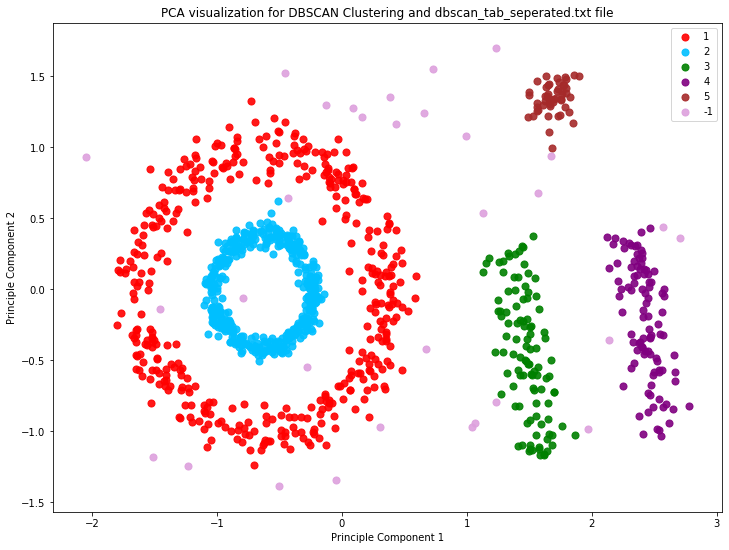

In [11]:
pca_data = PCA(n_components=2).fit_transform(input_matrix)

plotData(file_name, pca_data, cluster_list)